<a href="https://colab.research.google.com/github/Bossism/DailyStudy/blob/master/fake_news_pair_classification_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import jieba.posseg as pseg
import keras
import numpy as np

train = pd.read_csv("train.csv", index_col=0)
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
# print(train.head(3))

# 只看中文新闻
cols = ['title1_zh', 'title2_zh', 'label']
train = train.loc[:, cols]
# print(train.head(3))

# 将新闻标题切成一个个有意义的token
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return " ".join([word for word,flag in words if flag != 'x'])

missing_values_count = train.isnull().sum()
print(missing_values_count[0:3])
print(train.shape)
train = train.dropna()
print(train.shape)

title1_zh    0
title2_zh    7
label        0
dtype: int64
(320552, 3)
(320545, 3)


### 文本分词

In [28]:
train['title1_tokenized'] = train.loc[:, 'title1_zh'].apply(jieba_tokenizer)
train['title2_tokenized'] = train.loc[:, 'title2_zh'].apply(jieba_tokenizer)
print(train.iloc[:, [0, 3]].head())
print(train.iloc[:, [1, 4]].head())

                            title1_zh  \
id                                      
0       2017养老保险又新增两项，农村老人人人可申领，你领到了吗   
3   "你不来深圳，早晚你儿子也要来"，不出10年深圳人均GDP将超香港   
1   "你不来深圳，早晚你儿子也要来"，不出10年深圳人均GDP将超香港   
2   "你不来深圳，早晚你儿子也要来"，不出10年深圳人均GDP将超香港   
9                "用大蒜鉴别地沟油的方法,怎么鉴别地沟油   

                                   title1_tokenized  
id                                                   
0          2017 养老保险 又 新增 两项 农村 老人 人人 可 申领 你 领到 了 吗  
3   你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港  
1   你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港  
2   你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港  
9                        用 大蒜 鉴别 地沟油 的 方法 怎么 鉴别 地沟油  
                     title2_zh                      title2_tokenized
id                                                                  
0     警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京     警方 辟谣 鸟巢 大会 每人 领 5 万 仍 有 老人 坚持 进京
3    深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小    深圳 GDP 首 超 香港 深圳 统计局 辟谣 只是 差距 在 缩小
1         GDP首超香港？深圳澄清：还差一点点……              GDP 首 超 香港 深圳 

In [29]:
train.shape

(320545, 5)

### 建立字典并将文本转化成数字序列

In [31]:
from keras import preprocessing
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words = MAX_NUM_WORDS)
# 为新闻A和新闻B中的标题创造字典
print(type(train))
corpus_x1 = train.title1_tokenized
corpus_x2 = train.title2_tokenized
corpus = pd.concat([corpus_x1, corpus_x2])
# 这些文本的集合被称为语料库（Text Corpus），代表着所有的文本数据
print(corpus.shape)
print(pd.DataFrame(corpus.iloc[:5], columns=['title']))
# 建立字典
tokenizer.fit_on_texts(corpus)
x1_train = tokenizer.texts_to_sequences(corpus_x1)
x2_train = tokenizer.texts_to_sequences(corpus_x2)
print(x1_train[:1])
for seq in x1_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

<class 'pandas.core.frame.DataFrame'>
(641090,)
                                              title
id                                                 
0          2017 养老保险 又 新增 两项 农村 老人 人人 可 申领 你 领到 了 吗
3   你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
1   你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
2   你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
9                        用 大蒜 鉴别 地沟油 的 方法 怎么 鉴别 地沟油
[[217, 1268, 32, 1178, 5967, 25, 489, 2877, 116, 5559, 4, 1850, 2, 13]]
['2017', '养老保险', '又', '新增', '两项', '农村', '老人', '人人', '可', '申领', '你', '领到', '了', '吗']


### 序列的Zero Padding

In [32]:
MAX_SEQUENCE_LENGTH = 20
x1_train = keras.preprocessing.sequence.pad_sequences(x1_train, maxlen=MAX_SEQUENCE_LENGTH)
x2_train = keras.preprocessing.sequence.pad_sequences(x2_train, maxlen=MAX_SEQUENCE_LENGTH)
print(x1_train[:5])

[[   0    0    0    0    0    0  217 1268   32 1178 5967   25  489 2877
   116 5559    4 1850    2   13]
 [   0    4   10   47  678 2558    4  166   34   17   47 5150   63   15
   678 4502 3211   23  284 1181]
 [   0    4   10   47  678 2558    4  166   34   17   47 5150   63   15
   678 4502 3211   23  284 1181]
 [   0    4   10   47  678 2558    4  166   34   17   47 5150   63   15
   678 4502 3211   23  284 1181]
 [   0    0    0    0    0    0    0    0    0    0    0   31  320 3372
  3062    1   95   98 3372 3062]]


### 将label做one-hot coding

In [39]:
from keras.utils import np_utils
label_to_index = {
    'unrelated':0,
    'agreed':1,
    'disagreed':2
}
y_train = train.label.apply(lambda x:label_to_index[x])
y_train = np.asarray(y_train).astype('float32')
print(y_train[:5])
y_train = np_utils.to_categorical(y_train)
print(y_train[:5])

[0. 0. 0. 0. 1.]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


### 切割训练数据集、验证数据集

In [40]:
from sklearn.model_selection import train_test_split

VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527
x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(x1_train, x2_train, y_train, test_size=VALIDATION_RATIO,
                                                      random_state=RANDOM_STATE)


### 词向量：将词汇表达成有意义的向量

In [44]:
x1_train.shape
#如果能把每一个词都表示成一个有实际意义的词向量，神经网络就能帮我们找到潜藏在大量词汇中的语义关系，进一步改善NLP任务的精确度
#我们不用手动设置每个词汇的词矢量，可以随机初始化所有的词矢量，并利用反向传播算法，让神经网络自动学到一组适合当前NLP任务的词向量
#在NLP中，这种将一个词汇或者句子转化为一个实数词向量的技术被称为词嵌入（Word Embedding）
# NUM_EMBEDDING_DIM = 3
# embedding_layer = layer.Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM)

(288490, 20)

### 孪生神经网络结构

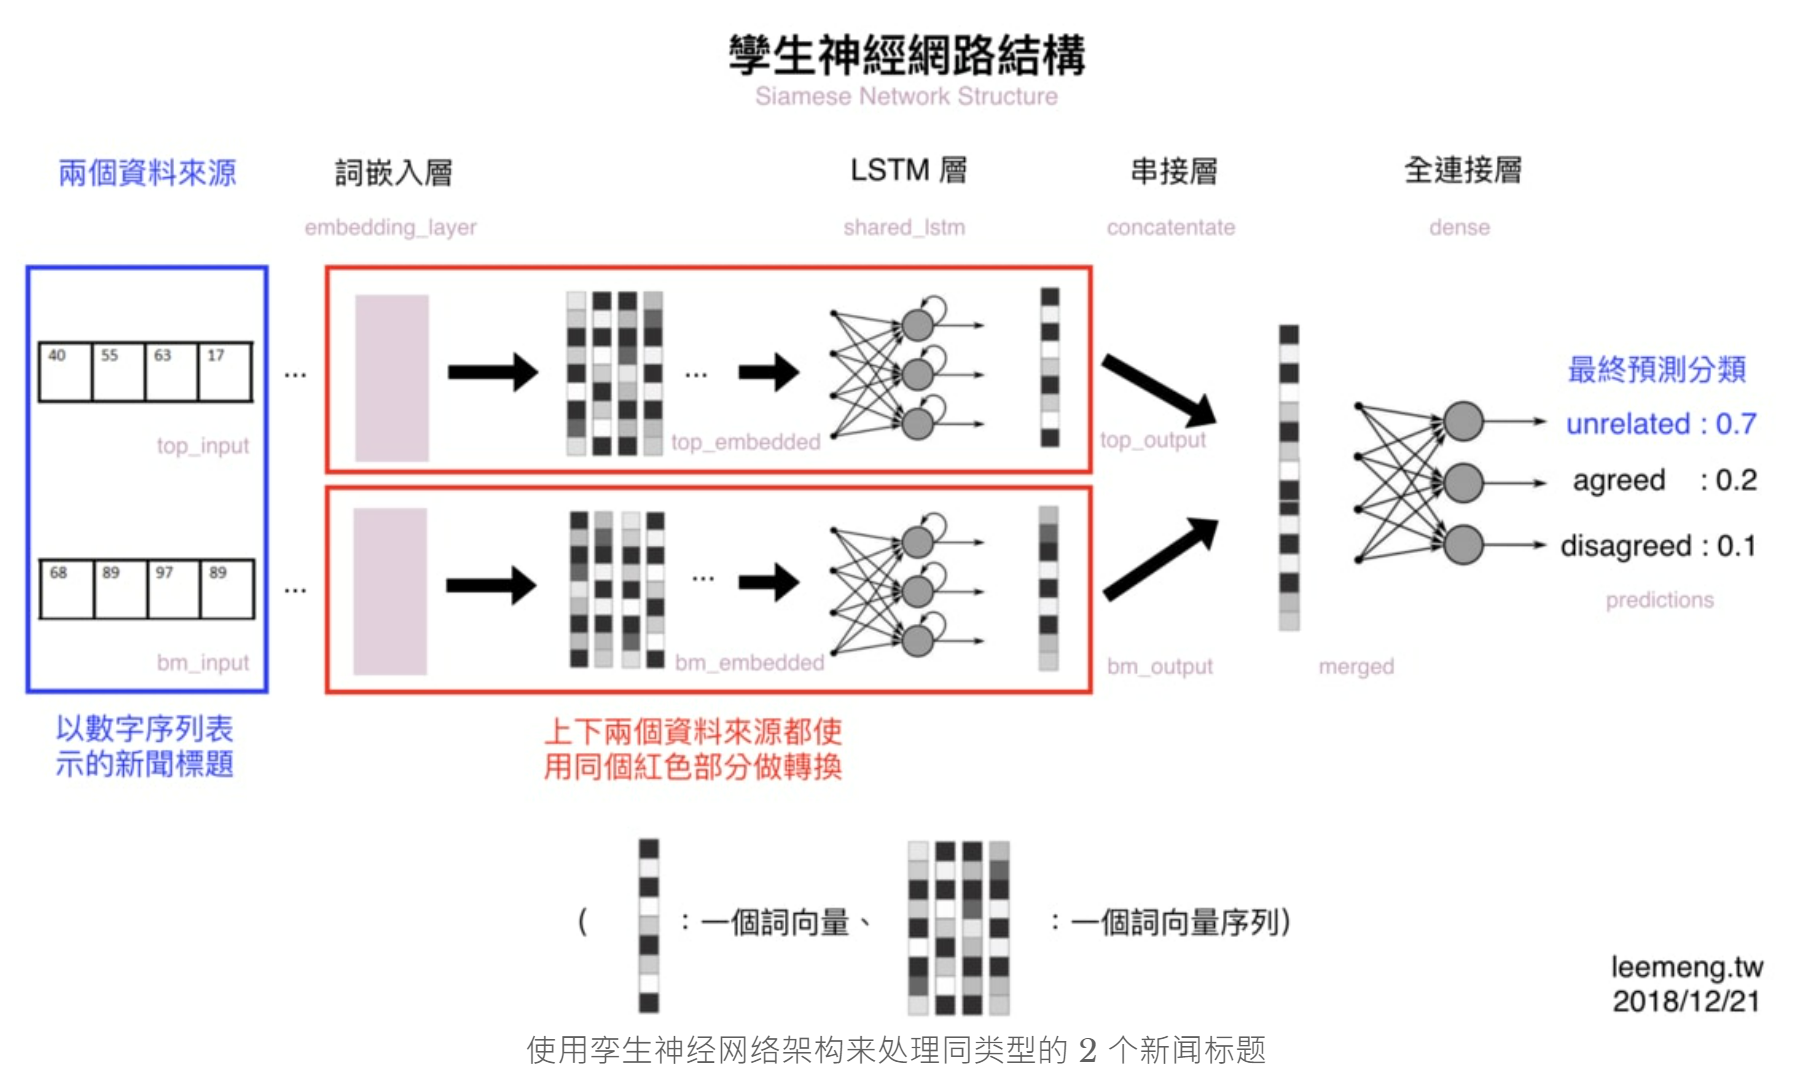

### 定义神经网络的架构

In [45]:
# 有几个分类
NUM_CLASSES = 3

# 语料库中最多有多少个词条
MAX_NUM_WORDS = 10000

# 一个标题最长有几个单词
MAX_SEQUENCE_LENGTH = 20

# 一个词向量的维度
NUM_EMBEDDING_DIM = 256

# LSTM输出维度
NUM_LSTM_UNITS = 128

In [47]:
from keras import Input
from keras.layers import Embedding,LSTM,concatenate,Dense
from keras.models import Model

top_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
bm_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')

embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(top_input)
bm_embedded = embedding_layer(bm_input)

shared_lstm = LSTM(NUM_LSTM_UNITS)
top_output = shared_lstm(top_embedded)
bm_output = shared_lstm(bm_embedded)

merged = concatenate([top_output, bm_output], axis=-1)

dense =  Dense(units=NUM_CLASSES, activation='softmax')
predictions = dense(merged)

model = Model(inputs=[top_input, bm_input], outputs=predictions)

为了确保Keras定义出的模型架构与预期的相同，我们将其画出来

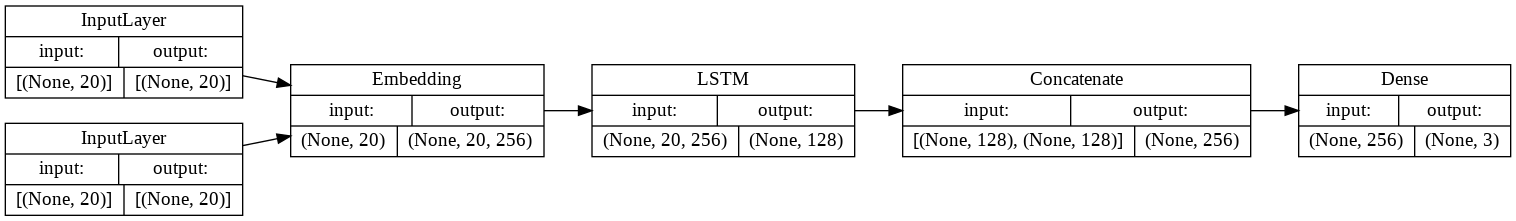

In [54]:
from keras.utils.vis_utils import plot_model
plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 256)      2560000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          197120      embedding[0][0]              

### 决定如何衡量模型的表现

In [56]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

### 训练模型并挑选出最好的结果

In [58]:
BATCH_SIZE = 512

NUM_EPOCHS = 10

history = model.fit(
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(
        [x1_val, x2_val], 
        y_val
    ),
    shuffle=True
)

Epoch 1/10
564/564 [==============================] - 42s 35ms/step - loss: 0.5474 - accuracy: 0.7472 - val_loss: 0.4170 - val_accuracy: 0.8067
Epoch 2/10
564/564 [==============================] - 19s 34ms/step - loss: 0.3821 - accuracy: 0.8263 - val_loss: 0.3872 - val_accuracy: 0.8253
Epoch 3/10
564/564 [==============================] - 18s 32ms/step - loss: 0.3410 - accuracy: 0.8487 - val_loss: 0.3789 - val_accuracy: 0.8291
Epoch 4/10
564/564 [==============================] - 18s 32ms/step - loss: 0.3137 - accuracy: 0.8637 - val_loss: 0.3837 - val_accuracy: 0.8287
Epoch 5/10
564/564 [==============================] - 19s 34ms/step - loss: 0.2927 - accuracy: 0.8754 - val_loss: 0.3795 - val_accuracy: 0.8405
Epoch 6/10
564/564 [==============================] - 19s 34ms/step - loss: 0.2725 - accuracy: 0.8848 - val_loss: 0.3780 - val_accuracy: 0.8360
Epoch 7/10
564/564 [==============================] - 18s 32ms/step - loss: 0.2561 - accuracy: 0.8937 - val_loss: 0.3660 - val_accuracy:

### 进行预测并提交结果

In [61]:
import pandas as pd
test = pd.read_csv("test.csv", index_col=0)
print(test.head(3))
test = test.dropna()
test['title1_tokenized'] = test.loc[:, 'title1_zh'].apply(jieba_tokenizer)
test['title2_tokenized'] = test.loc[:, 'title2_zh'].apply(jieba_tokenizer)
x1_test = tokenizer.texts_to_sequences(test.title1_tokenized)
x2_test = tokenizer.texts_to_sequences(test.title2_tokenized)
x1_test = keras.preprocessing.sequence.pad_sequences(x1_test, maxlen=MAX_SEQUENCE_LENGTH)
x2_test = keras.preprocessing.sequence.pad_sequences(x2_test, maxlen=MAX_SEQUENCE_LENGTH)
predictions = model.predict([x1_test, x2_test])
predictions[:5]

          tid1    tid2                        title1_zh  \
id                                                        
321187  167562   59521  萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大   
321190  167564   91315              萨达姆被捕后告诫美国的一句话，发人深思   
321189  167563  167564    萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗   

                          title2_zh  \
id                                    
321187  辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？   
321190    10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国   
321189          萨达姆被捕后告诫美国的一句话，发人深思   

                                                title1_en  \
id                                                          
321187  egypt 's presidential election failed to win m...   
321190  A message from Saddam Hussein after he was cap...   
321189  Will the United States wage war on Iraq withou...   

                                                title2_en  
id                                                         
321187  Lyon! Lyon officials have denied that Felipe F...  
321190  The Top 10 Ame

array([[9.7389549e-01, 3.0873431e-05, 2.6073646e-02],
       [9.7162402e-01, 4.0856186e-05, 2.8335147e-02],
       [7.8156543e-01, 2.1841073e-01, 2.3808294e-05],
       [9.8617852e-01, 1.0967741e-03, 1.2724812e-02],
       [9.0446693e-01, 3.7973167e-04, 9.5153339e-02]], dtype=float32)

In [67]:
index_to_label = {v: k for k, v in label_to_index.items()}
test['Category'] = [index_to_label[idx] for idx in np.argmax(predictions, axis=1)]

submission = test.loc[:, ['Category']].reset_index()
submission.columns = ['Id', 'Category']
submission.head()

,Id,Category
0,321187,unrelated
1,321190,unrelated
2,321189,unrelated
3,321193,unrelated
4,321191,unrelated


In [68]:
submission.to_csv('./res.csv', encoding='utf-8')